# SECTION 5.1: MERGERS AS THE MAIN CAUSE OF FAILURE

In [1]:
# TEST DELTA DEPENDENCIES WITHOUT MERGER CRITERION AND ONLY ABOVE 2 GYR

import os
import sys
import glob
from scipy import stats
import cuspcore_go
from cuspcore_aux import *
import pickle
import numpy
import scipy
from scipy.special import erf

Ttype='Tmulti'
rmin_evolve=10**-1.75
rmax_evolve=1.
linear_slopes=False
t_min=3.
merger_thr=1.
Dfit_threshold=0.10

sims=[sim[52:60] for sim in glob.glob('/cs/sci/freundlich/CUSPCORE/ARTICLE/output_20190503_g[!s]*[!temp].pickle')]

t1_array_all=[]
t2_array_all=[]
Dsnapshot_all=[]
delta_all=[]
delta_i_all=[]
fmean_all=[]
fstd_all=[]
fmerger_all=[]
fprofile_all=[]
fprofile_simname=[]

for sim in sims:
    output_file_sim='/cs/sci/freundlich/CUSPCORE/ARTICLE/output_20190503_%s.pickle'%sim
    with open(output_file_sim) as f:
        output_sim = pickle.load(f)
    
    [percent_tot,t1_array,t2_array,Dsnapshot,delta,delta_i,fmean,fstd,fmerger,fprofile, fprofile_simname,criteria_threshold]=output_sim
    t1_array_all.append(t1_array[0])
    t2_array_all.append(t2_array[0])
    Dsnapshot_all.append(Dsnapshot[0])
    delta_all.append(delta[0])
    delta_i_all.append(delta_i[0])
    fmean_all.append(fmean[0])
    fstd_all.append(fstd[0])
    fmerger_all.append(fmerger[0])
    fprofile_all.append(fprofile)
    
output=[percent_tot,t1_array_all,t2_array_all,Dsnapshot_all,delta_all,delta_i_all,fmean_all,fstd_all,fmerger_all,fprofile_all, fprofile_simname,criteria_threshold]
count_output=count_successes_all(sims,output,merger_threshold=0.1,fit_threshold=0.05)

print 'Load: Done!'

########################################################

[percent_tot,t1_array_all,t2_array_all,Dsnapshot_all,delta_all,delta_i_all,fmean_all,fstd_all,fmerger_all,fprofile_all, fprofile_simname,criteria_threshold] =output
ngalaxies = shape(t1_array_all)[0]

########################################################

##### LOAD PROPERTY NAMES
catalog='/cs/sci/freundlich/CUSPCORE/catalogs/NIHAO_a%.4f.txt'%1.
colnames=genfromtxt(catalog,max_rows=1,dtype='S20')

##### LOAD TIMES
import pickle
directory='/cs/sci/freundlich/CUSPCORE/NIHAO_data/'
with open(directory+'NIHAO-%s.pickle'%sims[0][1:]) as f:
            gl = pickle.load(f)

a_array=[]
for (i,ss) in zip(range(size(gl)),gl):
            a_array.append(ss['a'])         
        
a_array=array(a_array)
z_array = 1./a_array - 1.
logz=log10(z_array)

time=array(t2_array_all).flatten().copy()

n_outputs=size(a_array)
sim_list=[]
i_array=[]
for i in range(size(sims)):
    sim_list=sim_list+[sims[i]]*n_outputs
    i_array=i_array+[i for i in range(n_outputs)]

sim_list=array(sim_list)
i_array=array(i_array)

#### GET DELTA AND SUCCESS 
delta=array(delta_all).flatten().copy()
success=delta<Dfit_threshold

#dmax=0.4
delta_red=delta.copy()
delta_red[time<t_min]=nan*ones_like(delta_red[time<t_min])

dsim=abs(array(Dsnapshot_all).flatten().copy())
dsim_red=dsim.copy()

#### MASS RATIOS
frms=array(fmean_all).flatten().copy()
frms[frms==-inf]=nan
fmerger=abs(array(fmerger_all).flatten()).copy()
fmerger[fmerger==-inf]=nan
previous_fmerger=array([nan]+fmerger[:-1].tolist()).copy()

#fmax=0.35
frms_red=frms.copy()
fmerger_red=fmerger.copy()
previous_fmerger_red=previous_fmerger.copy()

frms_red[log10(frms_red)==-inf]=nan
fmerger_red[log10(fmerger_red)==-inf]=nan

#### QUANTITIES FROM FANGZHOU JIANG'S CATALOG

mvir=[]
mstar=[]
mgas=[]
mcold=[]
SFR=[]
re_star=[]
n_sersic=[]
cnfw=[]
q=[]
p=[]

for ID in sims:
    for a in a_array:
        if a==a_array[0] or a ==a_array[1]:
            mvir.append(nan)
            mstar.append(nan)
            mgas.append(nan)
            mcold.append(nan)
            SFR.append(nan)
            re_star.append(nan)
            n_sersic.append(nan)
            cnfw.append(nan)
            p.append(nan)
            q.append(nan)
        else:
            catalog='/cs/sci/freundlich/CUSPCORE/catalogs/NIHAO_a%.4f.txt'%a
            data=genfromtxt(catalog,skip_header =1)
            try:
                ok_fangzhou,r12_fangzhou,rvir_fangzhou,mvir_fangzhou,mstar_fangzhou=get_fangzhou_radii(ID,[a],get_stars=True)
                i_ID=where(data[:,0]==float(ID[1:]))[0][0]
                mvir.append(mvir_fangzhou[0])
                mstar.append(data[i_ID,17])
                mgas.append(data[i_ID,18])
                mcold.append(data[i_ID,19])
                SFR.append(data[i_ID,20])
                re_star.append(data[i_ID,21])
                n_sersic.append(data[i_ID,32])
                cnfw.append(data[i_ID,12])
                q.append(data[i_ID,33])
                p.append(data[i_ID,34])    
            except:
                mvir.append(nan)
                mstar.append(nan)
                mgas.append(nan)
                mcold.append(nan)
                SFR.append(nan)
                re_star.append(nan)
                n_sersic.append(nan)
                cnfw.append(nan)
                q.append(nan)
                p.append(nan)

mvir=array(mvir)
mstar=array(mstar)
mgas=array(mgas)
mcold=array(mcold)
SFR=array(SFR)
re_star=array(re_star)
n_sersic=array(n_sersic)
cnfw=array(cnfw)
q=array(q)
p=array(p)


f=sqrt(1-p**2)
e=sqrt(1-q**2)
ef=e-f
epf=e+f

mugas=mgas/mstar
muhot=(mgas-mcold)/mstar
mucold=mcold/mstar

mugas_red=mugas.copy()
mugas_red[mugas_red>50]=nan*ones_like(mugas_red[mugas_red>50])
mucold_red=mucold.copy()
mucold_red[mucold_red>50]=nan*ones_like(mucold_red[mucold_red>50])

fgas=mgas/(mstar+mgas+mvir)
fcold=mcold/(mstar+mgas)
fhot=(mgas-mcold)/(mstar+mgas)
fb=(mgas+mstar)/(mgas+mstar+mvir)
fb_gas=mgas/(mgas+mstar+mvir)
fb_star=mstar/(mgas+mstar+mvir)

mugas_dm=mgas/mvir
#######################################################

print 'Done!'

/cs/sci/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


g1.57e11: 22/50 = 44 percent success
        : 15/30 = 50 percent success without mergers
        : 12/23 = 52 percent success when fmean > 0.06
        : 3/7 = 43 percent success when fmean < 0.06
g4.99e10: 27/50 = 54 percent success
        : 27/41 = 66 percent success without mergers
        : 12/23 = 52 percent success when fmean > 0.06
        : 15/18 = 83 percent success when fmean < 0.06
g3.21e11: 18/50 = 36 percent success
        : 16/33 = 48 percent success without mergers
        : 11/26 = 42 percent success when fmean > 0.06
        : 5/7 = 71 percent success when fmean < 0.06
g3.44e10: 18/50 = 36 percent success
        : 17/24 = 71 percent success without mergers
        : 13/16 = 81 percent success when fmean > 0.06
        : 4/8 = 50 percent success when fmean < 0.06
g3.59e11: 19/50 = 38 percent success
        : 17/25 = 68 percent success without mergers
        : 12/17 = 71 percent success when fmean > 0.06
        : 5/8 = 62 percent success when fmean < 0.06
g6.12e10

In [2]:
# GET THE PROFILE PARAMETERS

rmin_fit=0.01

import treal_functions
import general_functions
import slopes_functions
import prepare_functions
import fitting as fit
import cuspcore_aux
import cuspcore_plots
import evolving

reload(treal_functions)
reload(general_functions)
reload(slopes_functions)
reload(prepare_functions)
reload(fit)
reload(cuspcore_aux)
reload(cuspcore_plots)
reload(evolving)

from general_functions import *
from slopes_functions import *
from prepare_functions import *
from cuspcore_aux import *
from cuspcore_plots import *
from evolving import *


pi_all=[]
pf_all=[]
pmodel_all=[]

sin_i_all=[]
sin_f_all=[]
sin_model_all=[]

cmax_i_all=[]
cmax_f_all=[]
cmax_model_all=[]

Dsin_if_all=[]
Dsin_model_all=[]
Rsin_if_all=[]
Rsin_model_all=[]

Dcmax_if_all=[]
Dcmax_model_all=[]
Rcmax_if_all=[]
Rcmax_model_all=[]

for sim in sims:
    try:
        output_file_sim='/cs/sci/freundlich/CUSPCORE/ARTICLE/poutput_20190503_%s.pickle'%sim
        with open(output_file_sim) as f:
            output_sim = pickle.load(f)

        [_, _, _, _, _, _, _, p_i, p_f, p_model]=output_sim
        pi_all.append(p_i[0])
        pf_all.append(p_f[0])
        pmodel_all.append(p_model[0])
        
        sin_i=[]
        sin_f=[]
        sin_model=[]
        for ioutput in range(shape(p_i[0])[0]):
            try:    sin_i.append(prf.s(rmin_fit*p_i[0][ioutput][4],p_i[0][ioutput]))
            except: sin_i.append(nan)
            try:    sin_f.append(prf.s(rmin_fit*p_f[0][ioutput][4],p_f[0][ioutput]))
            except: sin_f.append(nan)
            try:    sin_model.append(prf.s(rmin_fit*p_model[0][ioutput][4],p_model[0][ioutput]))
            except: sin_model.append(nan) 

        sin_i=array(sin_i)
        sin_f=array(sin_f)
        sin_model=array(sin_model)
        Dsin_if=sin_f-sin_i
        Dsin_model=sin_model-sin_i
        Rsin_if=sin_f/sin_i
        Rsin_model=sin_model/sin_i
        
        sin_i_all.append(sin_i)
        sin_f_all.append(sin_f)
        sin_model_all.append(sin_model)
        Dsin_if_all.append(Dsin_if)
        Dsin_model_all.append(Dsin_model)
        Rsin_if_all.append(Rsin_if)
        Rsin_model_all.append(Rsin_model)
        
        cmax_i=[]
        cmax_f=[]
        cmax_model=[]
        for ioutput in range(shape(p_i[0])[0]):
            try:    cmax_i.append(prf.cmax(p_i[0][ioutput]))
            except: cmax_i.append(nan)
            try:    cmax_f.append(prf.cmax(p_f[0][ioutput]))
            except: cmax_f.append(nan)
            try:    cmax_model.append(prf.cmax(p_model[0][ioutput]))
            except: cmax_model.append(nan) 

        cmax_i=array(cmax_i)
        cmax_f=array(cmax_f)
        cmax_model=array(cmax_model)
        Dcmax_if=cmax_f-cmax_i
        Dcmax_model=cmax_model-cmax_i
        Rcmax_if=cmax_f/cmax_i
        Rcmax_model=cmax_model/cmax_i
        
        cmax_i_all.append(cmax_i)
        cmax_f_all.append(cmax_f)
        cmax_model_all.append(cmax_model)
        Dcmax_if_all.append(Dcmax_if)
        Dcmax_model_all.append(Dcmax_model)
        Rcmax_if_all.append(Rcmax_if)
        Rcmax_model_all.append(Rcmax_model)

    except:
        print 'No poutput for %s'%sim

Dsin_if=array(Dsin_if_all).copy().flatten()
Dsin_model=array(Dsin_model_all).copy().flatten()
Rsin_if=array(Rsin_if_all).copy().flatten()
Rsin_model=array(Rsin_model_all).copy().flatten()

Dcmax_if=array(Dcmax_if_all).copy().flatten()
Dcmax_model=array(Dcmax_model_all).copy().flatten()
Rcmax_if=array(Rcmax_if_all).copy().flatten()
Rcmax_model=array(Rcmax_model_all).copy().flatten()

Dsnapshot_threshold=0.1
deltai=abs(array(delta_i_all).flatten().copy())

# DEFINE IS_SUCCESS_ALL AND IS_MERGER_ALL
is_merger_all=[]
is_success_all=[]
for i in range(size(sims)):
    for ioutput in range(n_outputs):
        if ioutput==0:
            is_merger_all.append(False)
            is_success_all.append(False)
        else:
            is_merger=(fmerger[i*n_outputs:(i+1)*n_outputs][ioutput]>0.1)
            is_success=((delta[i*n_outputs:(i+1)*n_outputs][ioutput]<=Dsnapshot_threshold) and ((delta[i*n_outputs:(i+1)*n_outputs][ioutput]<=deltai[i*n_outputs:(i+1)*n_outputs][ioutput]) or (dsim[i*n_outputs:(i+1)*n_outputs][ioutput]<=0.03)))
            is_merger_all.append(is_merger)
            is_success_all.append(is_success)

is_merger_all=array(is_merger_all)
is_success_all=array(is_success_all)
print 'Done!'

Dsin=log10(abs(array(sin_model_all).copy().flatten()-array(sin_f_all).copy().flatten()))
Dcmax=log10(abs(log10(array(cmax_model_all).copy().flatten())-log10(array(cmax_f_all).copy().flatten())))


Done!


In [3]:
sys.path.insert(0, '/cs/sci/freundlich/CUSPCORE/ARTICLE/figures')
import correlations
reload(correlations)
from correlations import *
import seaborn as sns

def array_nonan(array1,array2=array([])):
    if size(array2)==0:
        array2=array1
    if size(array1)<>size(array2):
        raise ValueError('The two arrays must have the same size')
    else:
        n=size(array2)-size(where(isnan(array2)))
        new_array=zeros(n)
        j=0
        for i in range(size(array2)):
            if not isnan(array2[i]):
                new_array[j]=array1[i]
                j=j+1
        return new_array

def do_hexplot(x,y,c=[],hexsize=12,xname='x',yname='y',cname='c',xlim=[],ylim=[],clim=[],x_ticks=[],y_ticks=[],x_labels=[],y_labels=[],c_ticks=[-2.5,-2.0,-1.5,-1.,-0.5,0],c_labels=[r'$-2.5$',r'$-2.0$',r'$-1.5$',r'$-1.0$',r'$-0.5$',r'$-0.0$'],savefile='',plot_colorbar=False,n_levels=0):

    space_down=0.18
    space_left=0.07
    width=0.21
    height=width*18./6.*3.5/3.
    figsize=(7,5)
    fontsize=24
    markersize=50

    if clim==[]:
        cmin=array_nonan(c).min()
        cmax=array_nonan(c).max()
    else:
        [cmin,cmax]=clim
        
    fig, ax = subplots(nrows=1, ncols=1,figsize=figsize)
    clf()
    ax=gca()

    if c<>[]:
        ax.hexbin(x, y, C=c,gridsize=hexsize,vmin=cmin,vmax=cmax,reduce_C_function=numpy.median,cmap='jet')
    else:
        ax.hexbin(x, y, gridsize=hexsize)

    if n_levels<>0:
        x=array_nonan(x,y)
        c=array_nonan(c,y)
        y=array_nonan(y,y)
        y=array_nonan(y,x)
        c=array_nonan(c,x)
        x=array_nonan(x,x)
        sns.set_style("white")
        sns.kdeplot(x,y,n_levels=n_levels,color='k')

    xmin, xmax = ax.get_xlim()
    xmin=xlim[0]
    xmax=xlim[1]
    ax.set_position([space_left+0.13,space_down, height*5./7., height])

    ax.set_xlabel(xname,fontsize=fontsize)
    ax.set_ylabel(yname,fontsize=fontsize)

    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels,fontsize=fontsize-4)

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels,fontsize=fontsize-4)

    mappable=ax.scatter(x+100., y, c=c,vmin=cmin,vmax=cmax,cmap='jet')
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.tick_params(axis='both',direction='in')
                   
    if plot_colorbar:
        cbar_ax = fig.add_axes([space_left+0.06+height*5./7.+0.13,space_down, 0.02*18./7., height])
        cbar=colorbar(mappable,cax=cbar_ax)
        cbar.set_ticks(c_ticks)
        cbar.set_ticklabels(c_labels)
        cbar.set_label(cname,fontsize=fontsize)
        tick_params(axis='both', which='major', labelsize=fontsize-4,direction='in')

        
    if savefile<>'':
        savefig(savefile)


/vol/sci/astro/home/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.
/cs/sci/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/cs/sci/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/cs/sci/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perfor

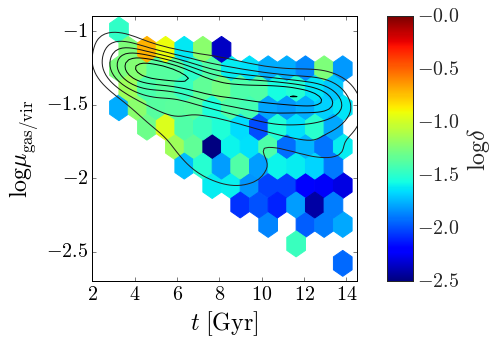

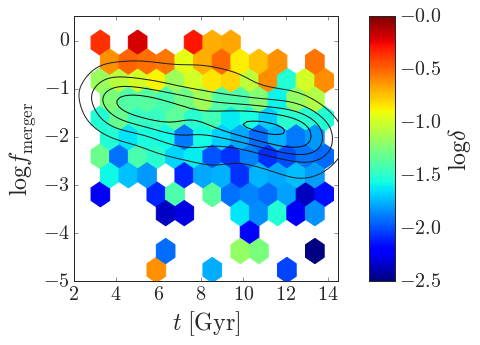

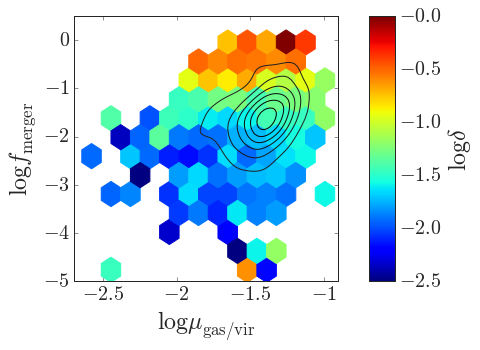

In [4]:
frms_red=frms.copy()
fmerger_red=fmerger.copy()
previous_fmerger_red=previous_fmerger.copy()

frms_red[log10(frms_red)==-inf]=nan
fmerger_red[log10(fmerger_red)==-inf]=nan

c=log10(abs(delta_red))[time>t_min]
cname=r'$\log\delta$'
clim=[-2.5,0]

n_levels=6#[0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
hexsize=12

###############################
# HEXPLOT delta=f(t,mugas)

x=time[time>t_min]
xname=r'$t$ $\rm [Gyr]$'
xlim=[2.,14.5]
x_ticks=[2,4,6,8,10,12,14]
x_labels=[r'$2$',r'$4$',r'$6$',r'$8$',r'$10$',r'$12$',r'$14$']

y=log10(mugas_dm)[time>t_min]
yname=r'$\log\mu_{\rm gas/vir}$'
ylim=[-2.7,-0.9]#[-0.01,0.09]
y_ticks=[-2.5,-2,-1.5,-1]#[0,0.02,0.04,0.06,0.08]
y_labels=[r'$-2.5$',r'$-2$',r'$-1.5$',r'$-1$']#[r'$0$',r'$2$',r'$4$',r'$6$',r'$8$']

savefile='/cs/sci/freundlich/CUSPCORE/ARTICLE/figures3/hexplot_delta_t_mu.pdf'
do_hexplot(x,y,c,hexsize=hexsize,xname=xname,yname=yname,cname=cname,xlim=xlim,ylim=ylim,clim=clim,x_ticks=x_ticks,y_ticks=y_ticks,x_labels=x_labels,y_labels=y_labels,savefile=savefile,plot_colorbar=True,n_levels=n_levels)

###############################
# HEXPLOT delta=f(t,fmerger)

x=time[time>t_min]
xname=r'$t$ $\rm [Gyr]$'
xlim=[2,14.5]
x_ticks=[2,4,6,8,10,12,14]
x_labels=[r'$2$',r'$4$',r'$6$',r'$8$',r'$10$',r'$12$',r'$14$']

y=log10(fmerger_red)[time>t_min]
yname=r'$\log f_{\rm merger}$'
ylim=[-5,0.5]
y_ticks=[-5,-4,-3,-2,-1,0]
y_labels=[r'$-5$',r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$']

savefile='/cs/sci/freundlich/CUSPCORE/ARTICLE/figures3/hexplot_delta_t_fmerger.pdf'
do_hexplot(x,y,c,hexsize=hexsize,xname=xname,yname=yname,cname=cname,xlim=xlim,ylim=ylim,clim=clim,x_ticks=x_ticks,y_ticks=y_ticks,x_labels=x_labels,y_labels=y_labels,savefile=savefile,plot_colorbar=True,n_levels=n_levels)

###############################
# HEXPLOT delta=f(fgas,fmerger)

x=log10(mugas_dm)[time>t_min]
xname=r'$\log\mu_{\rm gas/vir}$'
xlim=[-2.7,-0.9]#[-0.01,0.09]
x_ticks=[-2.5,-2,-1.5,-1]#[0,0.02,0.04,0.06,0.08]
x_labels=[r'$-2.5$',r'$-2$',r'$-1.5$',r'$-1$']#[r'$0$',r'$2$',r'$4$',r'$6$',r'$8$']

y=log10(fmerger_red)[time>t_min]
yname=r'$\log f_{\rm merger}$'
ylim=[-5,0.5]
y_ticks=[-5,-4,-3,-2,-1,0]
y_labels=[r'$-5$',r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$']

savefile='/cs/sci/freundlich/CUSPCORE/ARTICLE/figures3/hexplot_delta_fgas_fmerger.pdf'
do_hexplot(x,y,c,hexsize=hexsize,xname=xname,yname=yname,cname=cname,xlim=xlim,ylim=ylim,clim=clim,x_ticks=x_ticks,y_ticks=y_ticks,x_labels=x_labels,y_labels=y_labels,savefile=savefile,plot_colorbar=True,n_levels=n_levels)


/vol/sci/astro/home/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


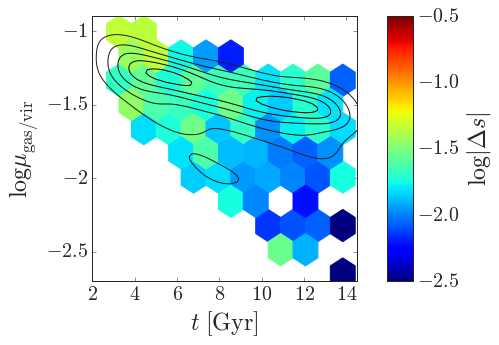

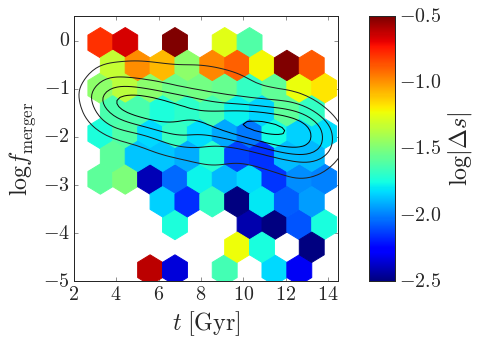

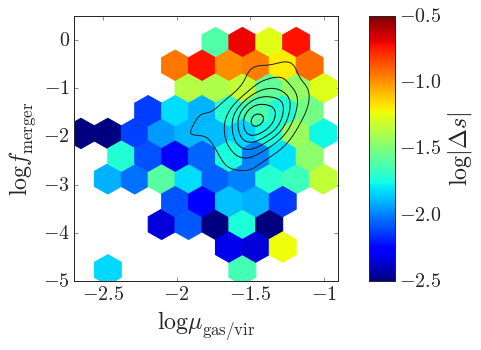

In [6]:
# Dsin

frms_red=frms.copy()
fmerger_red=fmerger.copy()
previous_fmerger_red=previous_fmerger.copy()

frms_red[log10(frms_red)==-inf]=nan
fmerger_red[log10(fmerger_red)==-inf]=nan

c=Dsin[time>t_min]
cname=r'$\log|\Delta s|$'
dname='Dsin'
clim=[-2,0]
c_ticks=[-2,-1.5,-1,-0.5,0]
c_labels=[r'$-2.0$',r'$-1.5$',r'$-1.0$',r'$-0.5$',r'$-0.0$']

n_levels=6#[0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
hexsize=9

###############################
# HEXPLOT delta=f(t,mugas)

x=time[time>t_min]
xname=r'$t$ $\rm [Gyr]$'
xlim=[2.,14.5]
x_ticks=[2,4,6,8,10,12,14]
x_labels=[r'$2$',r'$4$',r'$6$',r'$8$',r'$10$',r'$12$',r'$14$']

y=log10(mugas_dm)[time>t_min]
yname=r'$\log\mu_{\rm gas/vir}$'
ylim=[-2.7,-0.9]
y_ticks=[-2.5,-2,-1.5,-1]
y_labels=[r'$-2.5$',r'$-2$',r'$-1.5$',r'$-1$']

savefile='/cs/sci/freundlich/CUSPCORE/ARTICLE/figures3/hexplot_%s_t_mu.pdf'%dname
do_hexplot(x,y,c,hexsize=hexsize,xname=xname,yname=yname,cname=cname,xlim=xlim,ylim=ylim,clim=clim,x_ticks=x_ticks,y_ticks=y_ticks,x_labels=x_labels,y_labels=y_labels,savefile=savefile,plot_colorbar=True,n_levels=n_levels)

###############################
# HEXPLOT delta=f(t,fmerger)

x=time[time>t_min]
xname=r'$t$ $\rm [Gyr]$'
xlim=[2,14.5]
x_ticks=[2,4,6,8,10,12,14]
x_labels=[r'$2$',r'$4$',r'$6$',r'$8$',r'$10$',r'$12$',r'$14$']

y=log10(fmerger_red)[time>t_min]
yname=r'$\log f_{\rm merger}$'
ylim=[-5,0.5]
y_ticks=[-5,-4,-3,-2,-1,0]
y_labels=[r'$-5$',r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$']

savefile='/cs/sci/freundlich/CUSPCORE/ARTICLE/figures3/hexplot_%s_t_fmerger.pdf'%dname
do_hexplot(x,y,c,hexsize=hexsize,xname=xname,yname=yname,cname=cname,xlim=xlim,ylim=ylim,clim=clim,x_ticks=x_ticks,y_ticks=y_ticks,x_labels=x_labels,y_labels=y_labels,savefile=savefile,plot_colorbar=True,n_levels=n_levels)

###############################
# HEXPLOT delta=f(fgas,fmerger)

x=log10(mugas_dm)[time>t_min]
xname=r'$\log\mu_{\rm gas/vir}$'
xlim=[-2.7,-0.9]#[-0.01,0.09]
x_ticks=[-2.5,-2,-1.5,-1]#[0,0.02,0.04,0.06,0.08]
x_labels=[r'$-2.5$',r'$-2$',r'$-1.5$',r'$-1$']#[r'$0$',r'$2$',r'$4$',r'$6$',r'$8$']

y=log10(fmerger_red)[time>t_min]
yname=r'$\log f_{\rm merger}$'
ylim=[-5,0.5]
y_ticks=[-5,-4,-3,-2,-1,0]
y_labels=[r'$-5$',r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$']

savefile='/cs/sci/freundlich/CUSPCORE/ARTICLE/figures3/hexplot_%s_fgas_fmerger.pdf'%dname
do_hexplot(x,y,c,hexsize=hexsize,xname=xname,yname=yname,cname=cname,xlim=xlim,ylim=ylim,clim=clim,x_ticks=x_ticks,y_ticks=y_ticks,x_labels=x_labels,y_labels=y_labels,savefile=savefile,plot_colorbar=True,n_levels=n_levels)


/vol/sci/astro/home/sharonl/miniconda/envs/iyt32/lib/python2.7/site-packages/ipykernel_launcher.py:51: DeprecationWarning: elementwise != comparison failed; this will raise an error in the future.


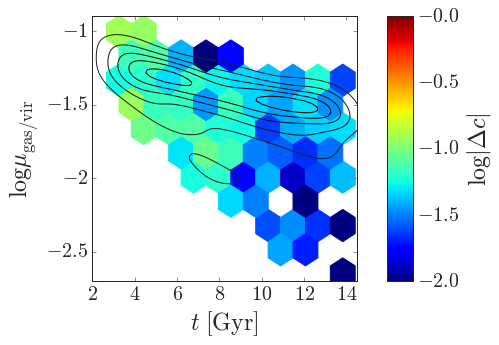

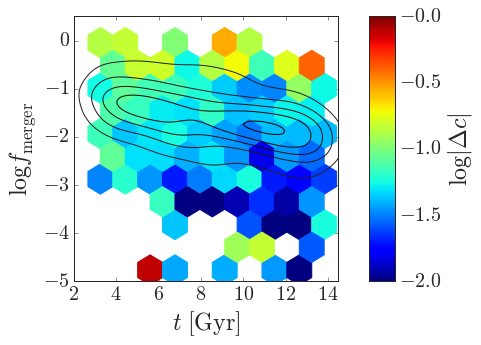

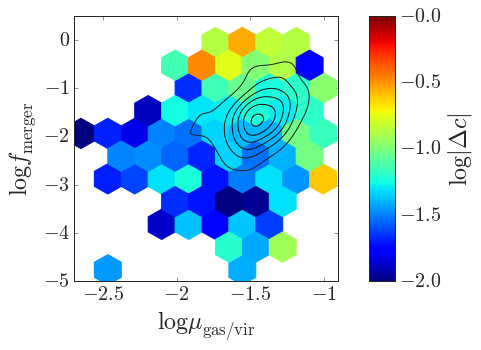

In [7]:
# Dsin

frms_red=frms.copy()
fmerger_red=fmerger.copy()
previous_fmerger_red=previous_fmerger.copy()

frms_red[log10(frms_red)==-inf]=nan
fmerger_red[log10(fmerger_red)==-inf]=nan

c=Dcmax[time>t_min]
cname=r'$\log|\Delta c|$'
dname='Dcmax'
clim=[-2,0]
c_ticks=[-2,-1.5,-1,-0.5,0]
c_labels=[r'$-2.0$',r'$-1.5$',r'$-1.0$',r'$-0.5$',r'$-0.0$']


n_levels=6#[0.,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.]
hexsize=9

###############################
# HEXPLOT delta=f(t,mugas)

x=time[time>t_min]
xname=r'$t$ $\rm [Gyr]$'
xlim=[2.,14.5]
x_ticks=[2,4,6,8,10,12,14]
x_labels=[r'$2$',r'$4$',r'$6$',r'$8$',r'$10$',r'$12$',r'$14$']

y=log10(mugas_dm)[time>t_min]
yname=r'$\log\mu_{\rm gas/vir}$'
ylim=[-2.7,-0.9]
y_ticks=[-2.5,-2,-1.5,-1]
y_labels=[r'$-2.5$',r'$-2$',r'$-1.5$',r'$-1$']

savefile='/cs/sci/freundlich/CUSPCORE/ARTICLE/figures3/hexplot_%s_t_mu.pdf'%dname
do_hexplot(x,y,c,hexsize=hexsize,xname=xname,yname=yname,cname=cname,xlim=xlim,ylim=ylim,clim=clim,x_ticks=x_ticks,y_ticks=y_ticks,x_labels=x_labels,y_labels=y_labels,c_ticks=c_ticks,c_labels=c_labels,savefile=savefile,plot_colorbar=True,n_levels=n_levels)

###############################
# HEXPLOT delta=f(t,fmerger)

x=time[time>t_min]
xname=r'$t$ $\rm [Gyr]$'
xlim=[2,14.5]
x_ticks=[2,4,6,8,10,12,14]
x_labels=[r'$2$',r'$4$',r'$6$',r'$8$',r'$10$',r'$12$',r'$14$']

y=log10(fmerger_red)[time>t_min]
yname=r'$\log f_{\rm merger}$'
ylim=[-5,0.5]
y_ticks=[-5,-4,-3,-2,-1,0]
y_labels=[r'$-5$',r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$']

savefile='/cs/sci/freundlich/CUSPCORE/ARTICLE/figures3/hexplot_%s_t_fmerger.pdf'%dname
do_hexplot(x,y,c,hexsize=hexsize,xname=xname,yname=yname,cname=cname,xlim=xlim,ylim=ylim,clim=clim,x_ticks=x_ticks,y_ticks=y_ticks,x_labels=x_labels,y_labels=y_labels,c_ticks=c_ticks,c_labels=c_labels,savefile=savefile,plot_colorbar=True,n_levels=n_levels)

###############################
# HEXPLOT delta=f(fgas,fmerger)

x=log10(mugas_dm)[time>t_min]
xname=r'$\log\mu_{\rm gas/vir}$'
xlim=[-2.7,-0.9]#[-0.01,0.09]
x_ticks=[-2.5,-2,-1.5,-1]#[0,0.02,0.04,0.06,0.08]
x_labels=[r'$-2.5$',r'$-2$',r'$-1.5$',r'$-1$']#[r'$0$',r'$2$',r'$4$',r'$6$',r'$8$']

y=log10(fmerger_red)[time>t_min]
yname=r'$\log f_{\rm merger}$'
ylim=[-5,0.5]
y_ticks=[-5,-4,-3,-2,-1,0]
y_labels=[r'$-5$',r'$-4$',r'$-3$',r'$-2$',r'$-1$',r'$0$']

savefile='/cs/sci/freundlich/CUSPCORE/ARTICLE/figures3/hexplot_%s_fgas_fmerger.pdf'%dname
do_hexplot(x,y,c,hexsize=hexsize,xname=xname,yname=yname,cname=cname,xlim=xlim,ylim=ylim,clim=clim,x_ticks=x_ticks,y_ticks=y_ticks,x_labels=x_labels,y_labels=y_labels,c_ticks=c_ticks,c_labels=c_labels,savefile=savefile,plot_colorbar=True,n_levels=n_levels)
